# EXAMPLE OF FEDERATED LEARNING APPLICATION
## Safety, Privacy and Legal Aspects

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import time

from keras.datasets import mnist
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import Dense, Activation, Flatten
from tensorflow import keras
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D


from matplotlib import pyplot as plt
import numpy as np

2022-03-30 14:21:04.126847: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-30 14:21:04.126871: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
# Read the MNIST data and process it. You can use reshape form numpy and to_categorical from 
# tensorflow.keras.utils
X_train = x_train
y_train = y_train

X_test = x_test
y_test = y_test

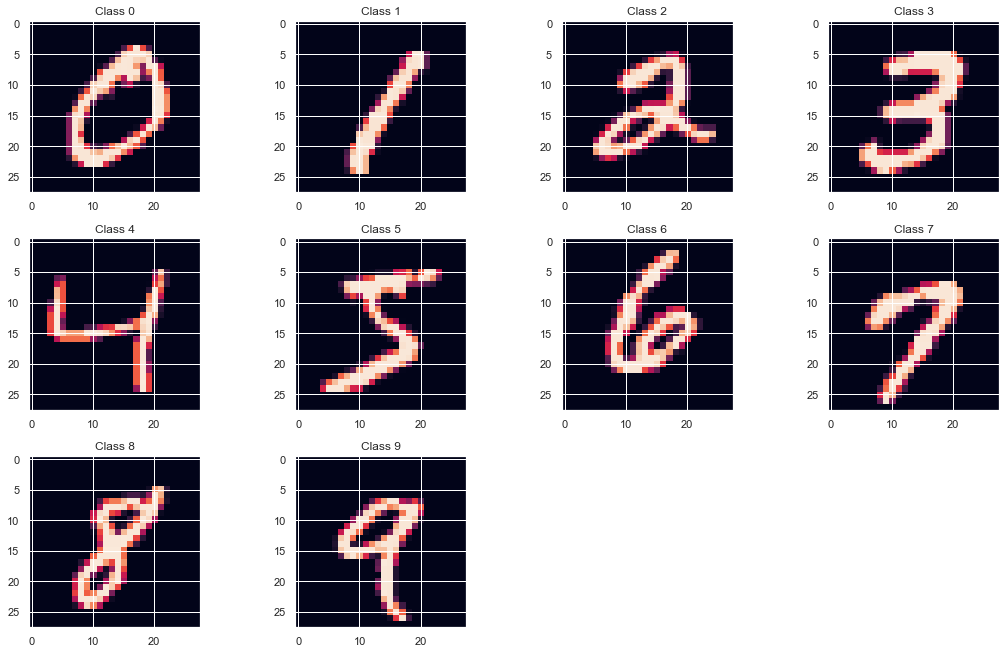

In [4]:
classes = list(set(y_train))

plot_side = int(np.sqrt(len(classes))) + 1
fig = plt.figure(figsize = (15, 12))

# Plot classes samples
for i, cla in enumerate(classes):
    ind = np.argwhere(y_train==i)[0]
    sample = np.squeeze(x_train[ind, :, :])

    ax = fig.add_subplot(plot_side, plot_side, i+1)
    ax.grid('off')
    ax.imshow(sample)
    ax.set_title('Class {}'.format(cla))

plt.tight_layout()
plt.show()

In [5]:
# Create 3 clients from the train data. You can do it as you prefer, either using slices 
# (e.g. client1_x = X_train[:len(X_train)//3]), creating a function that makes it automatic according
# to the number of clients desired (remember that two different customers cannot have data in common),
# or any other way you can think of.

import random 
rndm_sample = random.sample(range(0, 60000), 60000)

rndm_idx_1 = random.sample(rndm_sample, len(X_train) // 3)
rndm_idx_2 = random.sample(list(set(rndm_sample) - set(rndm_idx_1)), len(X_train) // 3)
rndm_idx_3 = list((set(rndm_sample) - set(rndm_idx_2)) - set(rndm_idx_1))


client1_x = X_train[rndm_idx_1]
client1_y = y_train[rndm_idx_1]

client2_x = X_train[rndm_idx_2]
client2_y = y_train[rndm_idx_2]

client3_x = X_train[rndm_idx_3]
client3_y = y_train[rndm_idx_3]

In [6]:
print(f'''Number of data for each customer: \n \t Client 1: {len(client1_x)}
     \t Client 2: {len(client2_x)} \n \t Client 3: {len(client3_x)}''')

Number of data for each customer: 
 	 Client 1: 20000
     	 Client 2: 20000 
 	 Client 3: 20000


In [7]:
# Check that the clients have been created correctly (that there is the same number of data in X_train as adding
# up all clients)
assert sum([len(client1_x), len(client2_x), len(client3_x)]) == len(X_train), 'Clients have not been created correctly'

In [8]:
# Create the model (neural network) with the layers you consider
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(100, activation="relu"),
    Dense(10, activation="softmax")
])
# If you wish you can modify the way the model is compiled
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = 'rmsprop',
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 100)               540900    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
__________________________________________________

2022-03-30 14:21:07.662888: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-30 14:21:07.662908: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-30 14:21:07.662922: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jor): /proc/driver/nvidia/version does not exist
2022-03-30 14:21:07.663089: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Creamos la función de agregación:

In [9]:
def aggregation(n_data1, n_data2, n_data3, w_1, w_2, w_3):
    """
    Aggregationfunction: weighted mean
    """
    factor_1 = np.array([n_data1 / (n_data1 + n_data2 + n_data3),
                         n_data2 / (n_data1 + n_data2 + n_data3),
                         n_data3 / (n_data1 + n_data2 + n_data3)])
    
    weights = list(map(lambda x, y: x * y, np.array([w_1, w_2, w_3]), factor_1))
    l = []
    for i in range(len(weights[0])):
        temp = 0
        for j in range(len(weights)):
            temp += weights[j][i]
        l.append(temp)
    return(l)
    

Entrenamos 3 veces cada modelo, actualizando los pesos tal y como se nos pide en el enunciado:

In [10]:
avg_weights = model.get_weights()

for iteration in range(3):
    print("Iteration %s. Client 1" % str(iteration+1))
    # Get the initial weights:
    initial_weights = avg_weights
    # Train for the first client (remember to give the model the initial weights)
    model.set_weights(initial_weights)
    model.fit(client1_x, client1_y, epochs = 5)
    # Obtain client 1 weights:
    weights_client1 = model.get_weights()

    print("Iteration %s. Client 2" % str(iteration+1))
    # Train for the second client (remember to give the model the initial weights).
    model.set_weights(initial_weights)
    model.fit(client2_x, client2_y, epochs = 5)
    # Get the weights for client 2: 
    weights_client2 = model.get_weights()
    
    print("Iteration %s. Client 3" % str(iteration+1))
    # Train for the third client (remember to set the initial weights for the model).
    model.set_weights(initial_weights)
    model.fit(client3_x, client3_y, epochs = 5)
    # Get the weights for client 3: 
    weights_client3 = model.get_weights()
    
    # Aggregate the weights obtained with each client using an aggregation function that performs a weighted average:
    avg_weights = aggregation(len(client1_x), len(client2_x), len(client3_x),
                              weights_client1, weights_client2, weights_client3)
    model.save('model' + str(iteration+1) + '.h5')

Iteration 1. Client 1
Epoch 1/5
625/625 [==============================] - 7s 11ms/step - loss: 1.1761 - sparse_categorical_accuracy: 0.9094
Epoch 2/5
625/625 [==============================] - 7s 11ms/step - loss: 0.0977 - sparse_categorical_accuracy: 0.9737
Epoch 3/5
625/625 [==============================] - 10s 15ms/step - loss: 0.0467 - sparse_categorical_accuracy: 0.9874
Epoch 4/5
625/625 [==============================] - 9s 14ms/step - loss: 0.0298 - sparse_categorical_accuracy: 0.9926
Epoch 5/5
625/625 [==============================] - 7s 11ms/step - loss: 0.0145 - sparse_categorical_accuracy: 0.9966
Iteration 1. Client 2
Epoch 1/5
625/625 [==============================] - 7s 11ms/step - loss: 1.0060 - sparse_categorical_accuracy: 0.9042
Epoch 2/5
625/625 [==============================] - 6s 10ms/step - loss: 0.1057 - sparse_categorical_accuracy: 0.9725
Epoch 3/5
625/625 [==============================] - 6s 10ms/step - loss: 0.0548 - sparse_categorical_accuracy: 0.9852
Epo

/home/jesus/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


282/625 [============>.................] - ETA: 3s - loss: 0.0762 - sparse_categorical_accuracy: 0.9817

KeyboardInterrupt: 

**HINT**: some functions you need to know: set_weights, get_weights. Create an auxiliary function to aggregate the weights. This function will receive the number of data for each client (so that the average is weighted), and the weights for each of them. 

Let $N$ be the number of clients and $n_i$ the number of data for each of these, remember that this aggregation function is given by:

$$
\sum_{i=1}^{N} w_{i} \cdot weights\_client\_i
$$

$$
w_i = \frac{n_i}{\sum_{i=1}^{N}n_{i}} \hspace{0.5cm} \forall i \in \{1,...,N\}
$$

In [ ]:
# Evaluate each saved model (you should have model1.h5, model2.h5 and model3.h5) with the test data,
# display and analyze the obtained results:
acc_hist = {}
auc_hist = {}

for i in range(3):
    
    my_model = load_model("model" + str(i+1) +".h5")

    my_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     optimizer = 'rmsprop',
                     metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
    
    my_pred_prob = my_model.predict(x_test)
    my_pred =  np.argmax(my_pred_prob, axis = -1)
    
    
    print("--------------------------------------------------------------")
    print("|                   PREDICTION WITH MODEL "+str(i+1)+"                  |")
    print("--------------------------------------------------------------")
    
    print("###################### CONFUSION MATRIX ######################")
    mat = confusion_matrix(y_test, my_pred)
    fig, ax = plt.subplots(figsize = (7,6))
    sns.set(font_scale = 1.3)
    sns.heatmap(mat.T, square = False, annot = True, fmt = 'd', cbar = False,
                xticklabels = range(0,10),
                yticklabels = range(0,10),
                cmap = sns.cubehelix_palette(light = 1, as_cmap = True))

    plt.xlabel('true label');
    plt.ylabel('predicted label');
    plt.show()
    
    
    time.sleep(1)
    print("################### CLASSIFICATION REPORT ###################")
    print(classification_report(y_test, my_pred))
    
    my_acc = accuracy_score(y_test, my_pred)
    print("Accuracy score: {}".format(my_acc))
    
    my_auc = roc_auc_score(y_test, my_pred_prob, multi_class = "ovr")
    print("ROC_AUC score: {}".format(my_auc))
    
    acc_hist["Model_" + str(i+1)]  = my_acc
    auc_hist["Model_" + str(i+1)]  = my_auc

Comparamos algunas métricas en fromato DataFrame para verlo más claro.

In [ ]:
df_acc = pd.DataFrame.from_dict(acc_hist, orient = "index", columns = ["Accuracy"])
df_auc = pd.DataFrame.from_dict(auc_hist, orient = "index", columns = ["AUC_ROC"])
df_acc.join(df_auc)

Como era de esperar, el accuracy crece según mejoramos el modelo. Lo mismo pasa con la métrica AUC.